# <font color='red'>Clustering Assignment</font>

**There will be some functions that start with the word "grader" ex: grader_actors(), grader_movies(), grader_cost1() etc, you should not change those function definition.<br><br>Every Grader function has to return True.**

**Please check [clustering assignment helper functions](https://drive.google.com/file/d/1V29KhKo3YnckMX32treEgdtH5r90DIjU/view?usp=sharing) notebook before attempting this assignment.**

*  Read graph from the given <font color='blue'>movie_actor_network.csv</font> (note that the graph is bipartite graph.)

*  Using stellergaph and gensim packages, get the dense representation(128dimensional vector) of every node in the graph. [Refer <font color='blue'>Clustering_Assignment_Reference.ipynb</font>]

* Split the dense representation into actor nodes, movies nodes.(Write you code in <font color='blue'>def data_split()</font>)


# <font color='red'>Task 1 : Apply clustering algorithm to group similar actors</font>

 1. For this task consider only the actor nodes 
 2. Apply any clustering algorithm of your choice <br>
    Refer : https://scikit-learn.org/stable/modules/clustering.html
 3. Choose the number of clusters for which you have maximum score of <b>$Cost1*Cost2$</b><br>
 4. Cost1 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(number of nodes in the largest connected component in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(total number of nodes in that cluster i)}}$ where N= number of clusters 
<br> (Write your code in <font color='blue'>def cost1()</font>)<br>
 5. Cost2 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(sum of degress of actor nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(number of unique movie nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}$ where N= number of clusters 
 <br> (Write your code in <font color='blue'>def cost2()</font>)<br>
 6. Fit the clustering algorithm with the opimal number_of_clusters and get the cluster number for each node <br>
 7. Convert the d-dimensional dense vectors of nodes into 2-dimensional using dimensionality reduction techniques (preferably TSNE)<br>
 8. Plot the 2d scatter plot, with the node vectors after step e and give colors to nodes such that same cluster nodes will have same color

<img src='https://i.imgur.com/4SPYPFa.jpg'>

# <font color='red'>Task 2 : Apply clustering algorithm to group similar movies</font>


1. For this task consider only the movie nodes
2. Apply any clustering algorithm of your choice
3.Choose the number of clusters for which you have maximum score of $Cost1*Cost2$ <br>

    Cost1 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(number of nodes in the largest connected component in the graph with the movie nodes and its actor neighbours in cluster i)}}{\text{(total number of nodes in that cluster i)}}$ where N= number of clusters <br>
(Write your code in <font color='blue'>def cost1()</font>)<br>
	
4. Cost2 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(sum of degress of movie nodes in the graph with the movie nodes and its actor neighbours in cluster i)}}{\text{(number of unique actor nodes in the graph with the movie nodes and its actor neighbours in cluster i)}}$ 
where N= number of clusters 
<br>(Write your code in <font color='blue'>def cost2()</font>)<br>


**Algorithm for actor nodes**

<pre>
	for number_of_clusters in [3, 5, 10, 30, 50, 100, 200, 500]:
		algo = clustering_algorith(clusters=number_of_clusters)
        # you will be passing a matrix of size N*d where N number of actor nodes and d is dimension from gensim
		algo.fit(the dense vectors of actor nodes) 
        You can get the labels for corresponding actor nodes (algo.labels_)
        Create a graph for every cluster(ie., if n_clusters=3, create 3 graphs)
        (You can use ego_graph to create subgraph from the actual graph)
        compute cost1,cost2 
           (if n_cluster=3, cost1=cost1(graph1)+cost1(graph2)+cost1(graph3) # here we are doing summation
            cost2=cost2(graph1)+cost2(graph2)+cost2(graph3)
		computer the metric Cost = Cost1*Cost2
	return number_of_clusters which have maximum Cost
	</pre>

In [2]:
pip install networkx==2.3

     |████████████████████████████████| 1.8MB 2.7MB/s 
  Created wheel for networkx: filename=networkx-2.3-py2.py3-none-any.whl size=1556409 sha256=7f78c74764777decb0a53ce311a426594b9bba29ca51ac43f227f9d3717f22c8
  Stored in directory: /root/.cache/pip/wheels/de/63/64/3699be2a9d0ccdb37c7f16329acf3863fd76eda58c39c737af
Successfully built networkx
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: networkx 2.5
    Uninstalling networkx-2.5:
      Successfully uninstalled networkx-2.5


In [3]:
pip install stellargraph

     |████████████████████████████████| 440kB 2.8MB/s 


In [4]:
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
# you need to have tensorflow 
from stellargraph.data import UniformRandomMetaPathWalk
from stellargraph import StellarGraph
from tqdm import tqdm_notebook

In [89]:
from sklearn.manifold import TSNE

In [5]:
from google.colab import files
file=files.upload()

Saving movie_actor_network.csv to movie_actor_network.csv


In [6]:
data=pd.read_csv('movie_actor_network.csv', index_col=False, names=['movie','actor'])

In [7]:
data.head()

,movie,actor
0,m1,a1
1,m2,a1
2,m2,a2
3,m3,a1
4,m3,a3


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9650 entries, 0 to 9649
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   movie   9650 non-null   object
 1   actor   9650 non-null   object
dtypes: object(2)
memory usage: 150.9+ KB


In [9]:
edges = [tuple(x) for x in data.values.tolist()]
edges[:5]

[('m1', 'a1'), ('m2', 'a1'), ('m2', 'a2'), ('m3', 'a1'), ('m3', 'a3')]

In [10]:
B = nx.Graph()
B.add_nodes_from(data['movie'].unique(), bipartite=0, label='movie')
B.add_nodes_from(data['actor'].unique(), bipartite=1, label='actor')
B.add_edges_from(edges, label='acted')

In [11]:
A = list(nx.connected_component_subgraphs(B))[0]

In [12]:
print("number of nodes", A.number_of_nodes())
print("number of edges", A.number_of_edges())

number of nodes 4703
number of edges 9650


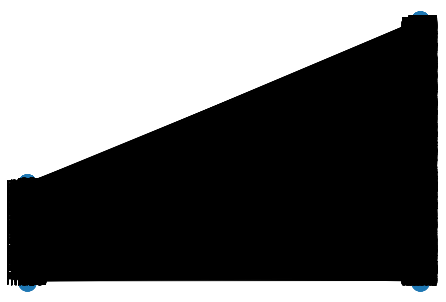

In [13]:
l, r = nx.bipartite.sets(A)
pos = {}

pos.update((node, (1, index)) for index, node in enumerate(l))
pos.update((node, (2, index)) for index, node in enumerate(r))
  
nx.draw(A, pos=pos, with_labels=True)
plt.show()

In [14]:
movies = []
actors = []
for i in A.nodes():
    if 'm' in i:
        movies.append(i)
    if 'a' in i:
        actors.append(i)
print('number of movies ', len(movies))
print('number of actors ', len(actors))

number of movies  1292
number of actors  3411


In [15]:
# Create the random walker
rw = UniformRandomMetaPathWalk(StellarGraph(A))

# specify the metapath schemas as a list of lists of node types.
metapaths = [
    ["movie", "actor", "movie"],
    ["actor", "movie", "actor"]
]

walks = rw.run(nodes=list(A.nodes()), # root nodes
               length=100,  # maximum length of a random walk
               n=1,        # number of random walks per root node 
               metapaths=metapaths
              )

print("Number of random walks: {}".format(len(walks)))

Number of random walks: 4703


In [16]:
from gensim.models import Word2Vec
model = Word2Vec(walks, size=128, window=5)

In [17]:
model.wv.vectors.shape  # 128-dimensional vector for each node in the graph

(4703, 128)

In [18]:
# Retrieve node embeddings and corresponding subjects
node_ids = model.wv.index2word  # list of node IDs
node_embeddings = model.wv.vectors  # numpy.ndarray of size number of nodes times embeddings dimensionality
node_targets = [ A.node[node_id]['label'] for node_id in node_ids]

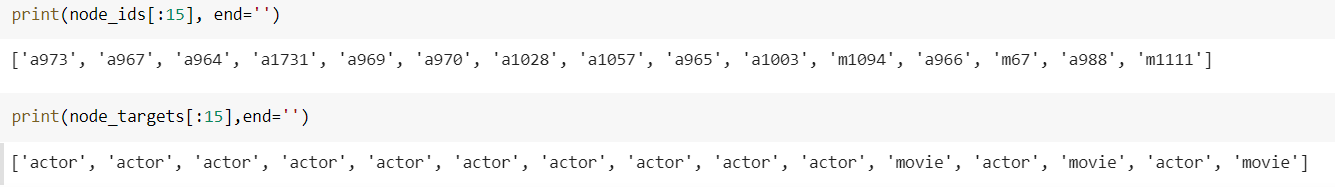

In [19]:
def data_split(node_ids,node_targets,node_embeddings):
    '''In this function, we will split the node embeddings into actor_embeddings , movie_embeddings '''
    actor_nodes,movie_nodes=[],[]
    actor_embeddings,movie_embeddings=[],[]
    # split the node_embeddings into actor_embeddings,movie_embeddings based on node_ids
    # By using node_embedding and node_targets, we can extract actor_embedding and movie embedding
    # By using node_ids and node_targets, we can extract actor_nodes and movie nodes
    for i in range(0,len(node_ids)):
      if(node_targets[i]=='actor' and 'a' in node_ids[i]):
        actor_nodes.append(node_ids[i])
        actor_embeddings.append(node_embeddings[i])
      else:
        movie_nodes.append(node_ids[i])
        movie_embeddings.append(node_embeddings[i])
    return actor_nodes,movie_nodes,actor_embeddings,movie_embeddings

In [20]:
actor_nodes,movie_nodes,actor_embeddings,movie_embeddings=data_split(node_ids,node_targets,node_embeddings)

<font color='cyan'>Grader function - 1</font>

In [21]:
def grader_actors(data):
    assert(len(data)==3411)
    return True
grader_actors(actor_nodes)

True

<font color='cyan'>Grader function - 2</font>

In [22]:
def grader_movies(data):
    assert(len(data)==1292)
    return True
grader_movies(movie_nodes)

True

<font color='blue'>Calculating cost1</font>

Cost1 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(number of nodes in the largest connected component in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(total number of nodes in that cluster i)}}$ where N= number of clusters <br><br>
<br>

In [23]:
def cost1(graph,number_of_clusters):
    '''In this function, we will calculate cost1'''
    cost1=((1/number_of_clusters)*(max(dict(graph.degree()).values())+1)/len(graph.nodes()))
    return cost1

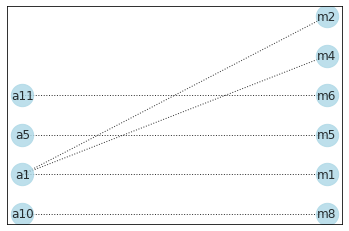

In [78]:
import networkx as nx
from networkx.algorithms import bipartite
graded_graph= nx.Graph()
graded_graph.add_nodes_from(['a1','a5','a10','a11'], bipartite=0) # Add the node attribute "bipartite"
graded_graph.add_nodes_from(['m1','m2','m4','m6','m5','m8'], bipartite=1)
graded_graph.add_edges_from([('a1','m1'),('a1','m2'),('a1','m4'),('a11','m6'),('a5','m5'),('a10','m8')])
l={'a1','a5','a10','a11'};r={'m1','m2','m4','m6','m5','m8'}
pos = {}
pos.update((node, (1, index)) for index, node in enumerate(l))
pos.update((node, (2, index)) for index, node in enumerate(r))
nx.draw_networkx(graded_graph, pos=pos, with_labels=True,node_color='lightblue',alpha=0.8,style='dotted',node_size=500)

<font color='cyan'>Grader function - 3</font>

In [79]:
graded_cost1=cost1(graded_graph,3)
def grader_cost1(data):
    assert(data==((1/3)*(4/10))) # 1/3 is number of clusters
    return True
grader_cost1(graded_cost1)

True

<font color='blue'>Calculating cost2</font>

Cost2 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(sum of degress of actor nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(number of unique movie nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}$ where N= number of clusters 

In [80]:
def cost2(graph,number_of_clusters):
    '''In this function, we will calculate cost1'''
    c=0
    for i in list(graph.nodes()):
      if('m' in i):
        c=c+1
    cost2= ((1/number_of_clusters)*(len(graph.edges())/c))
    
    return cost2

<font color='cyan'>Grader function - 4</font>

In [81]:
graded_cost2=cost2(graded_graph,3)
def grader_cost2(data):
    assert(data==((1/3)*(6/6))) # 1/3 is number of clusters
    return True
grader_cost2(graded_cost2)

True

<h2><font color='blue'>Grouping similar actors</font></h2>

In [170]:
def compute_cost(actor_nodes,model_object,edge_data,n):
  c1=0
  c2=0
  for group in range(0,n):

    al=[actor_nodes[i] for i in [i for i, e in enumerate(model_object.labels_) if e == group]]
    print(al[:5])
    el=[]
    ml=[]
    for i in al:
      for j in edge_data:
        if(i==j[1]):
          el.append(j)
          ml.append(j[0])
    ml=list(set(ml))
    graph=nx.Graph()
    graph.add_nodes_from(al,bipartite=0)
    graph.add_nodes_from(ml,bipartite=1)
    graph.add_edges_from(el)
    c1=c1+cost1(graph,n)
    c2=c2+cost2(graph,n)
  return c1*c2

<font color='blue'> Optimal No.of Clusters (actors) : </font>

In [87]:
best_cost=0
best_no_of_clusters=0
for nc in tqdm_notebook([3, 5, 10, 30, 50, 100, 200, 500]):
  kmeans=KMeans(n_clusters=nc)
  kmeans.fit(actor_embeddings)
  cost=compute_cost(actor_nodes,kmeans,list(A.edges()),nc)
  print('no.of clusters : {} , cost : {}'.format(nc,cost))
  if(cost>best_cost):
    best_cost=cost
    best_no_of_clusters=nc
print('optimal no.of clusters = {} , optimal cost = {}'.format(best_no_of_clusters,best_cost))

no.of clusters : 3 , cost : 1.634021984600394
no.of clusters : 5 , cost : 1.2884067487460102
no.of clusters : 10 , cost : 1.0615388510146246
no.of clusters : 30 , cost : 0.8278743236566584
no.of clusters : 50 , cost : 0.792368540061085
no.of clusters : 100 , cost : 0.7924341926009567
no.of clusters : 200 , cost : 0.7521161715672953
no.of clusters : 500 , cost : 0.8107669519802505

optimal no.of clusters = 3 , optimal cost = 1.634021984600394


<font color='blue'> Fitting cluster algorithm with optimal no_of_clusters : </font>

In [88]:
best_cluster=KMeans(n_clusters=best_no_of_clusters)
best_cluster.fit(actor_embeddings)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

<font color='blue'> d-dimenssion to 2-dimenssion (TSNE) :</font>

In [90]:
trans = TSNE(n_components=2)
actor_node_embeddings_2d = trans.fit_transform(actor_embeddings)

In [92]:
actor_node_embeddings_2d.shape

(3411, 2)

<font color='blue'> Plotting Clusters :</font>

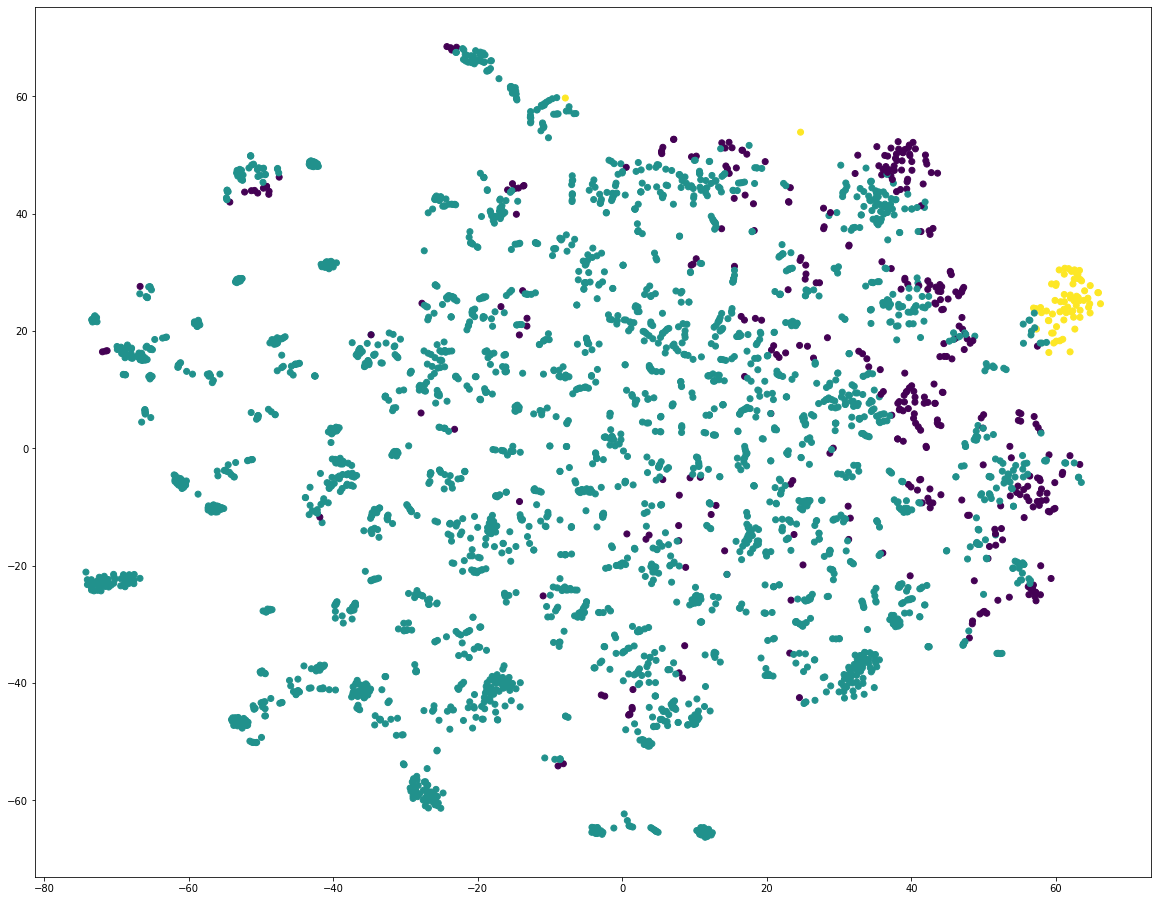

In [168]:
#https://stackoverflow.com/questions/28227340/kmeans-scatter-plot-plot-different-colors-per-cluster
plt.figure(figsize=(20,16))
plt.scatter(actor_node_embeddings_2d[:,0],actor_node_embeddings_2d[:,1],c=best_cluster.labels_.astype(float))
plt.show()

<h2><font color='blue'>Grouping similar movies</font></h2>

In [182]:
def compute_cost_movies(actor_nodes,model_object,edge_data,n):
  c1=0
  c2=0
  for group in range(0,n):
    al=[actor_nodes[i] for i in [i for i, e in enumerate(model_object.labels_) if e == group]]
    el=[]
    ml=[]
    for i in al:
      for j in edge_data:
        if(i==j[0]):
          el.append(j)
          ml.append(j[1])
    ml=list(set(ml))
    graph=nx.Graph()
    graph.add_nodes_from(al,bipartite=0)
    graph.add_nodes_from(ml,bipartite=1)
    graph.add_edges_from(el)
    c1=c1+cost1(graph,n)
    c2=c2+cost2(graph,n)
  return c1*c2

<font color='blue'> Optimal No.of Clusters (movies) : </font>

In [183]:
best_cost=0
best_no_of_clusters=0
for nc in tqdm_notebook([3, 5, 10, 30, 50, 100, 200, 500]):
  kmeans=KMeans(n_clusters=nc)
  kmeans.fit(movie_embeddings)
  cost=compute_cost_movies(movie_nodes,kmeans,list(A.edges()),nc)
  print('no.of clusters : {} , cost : {}'.format(nc,cost))
  if(cost>best_cost):
    best_cost=cost
    best_no_of_clusters=nc
print('optimal no.of clusters = {} , optimal cost = {}'.format(best_no_of_clusters,best_cost))

no.of clusters : 3 , cost : 3.431208636187303
no.of clusters : 5 , cost : 3.5641072056531486
no.of clusters : 10 , cost : 3.8859630910009924
no.of clusters : 30 , cost : 4.635872330094256
no.of clusters : 50 , cost : 5.3202207613308135
no.of clusters : 100 , cost : 5.610842248247094
no.of clusters : 200 , cost : 5.207512748581443
no.of clusters : 500 , cost : 4.136793162769111

optimal no.of clusters = 100 , optimal cost = 5.610842248247094


<font color='blue'> Fitting cluster algorithm with optimal no_of_clusters : </font>

In [184]:
best_cluster=KMeans(n_clusters=best_no_of_clusters)
best_cluster.fit(movie_embeddings)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=100, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

<font color='blue'> d-dimenssion to 2-dimenssion (TSNE) :</font>

In [185]:
trans = TSNE(n_components=2)
movie_embeddings_2d = trans.fit_transform(movie_embeddings)

In [186]:
movie_embeddings_2d.shape

(1292, 2)

<font color='blue'> Plotting Clusters :</font>

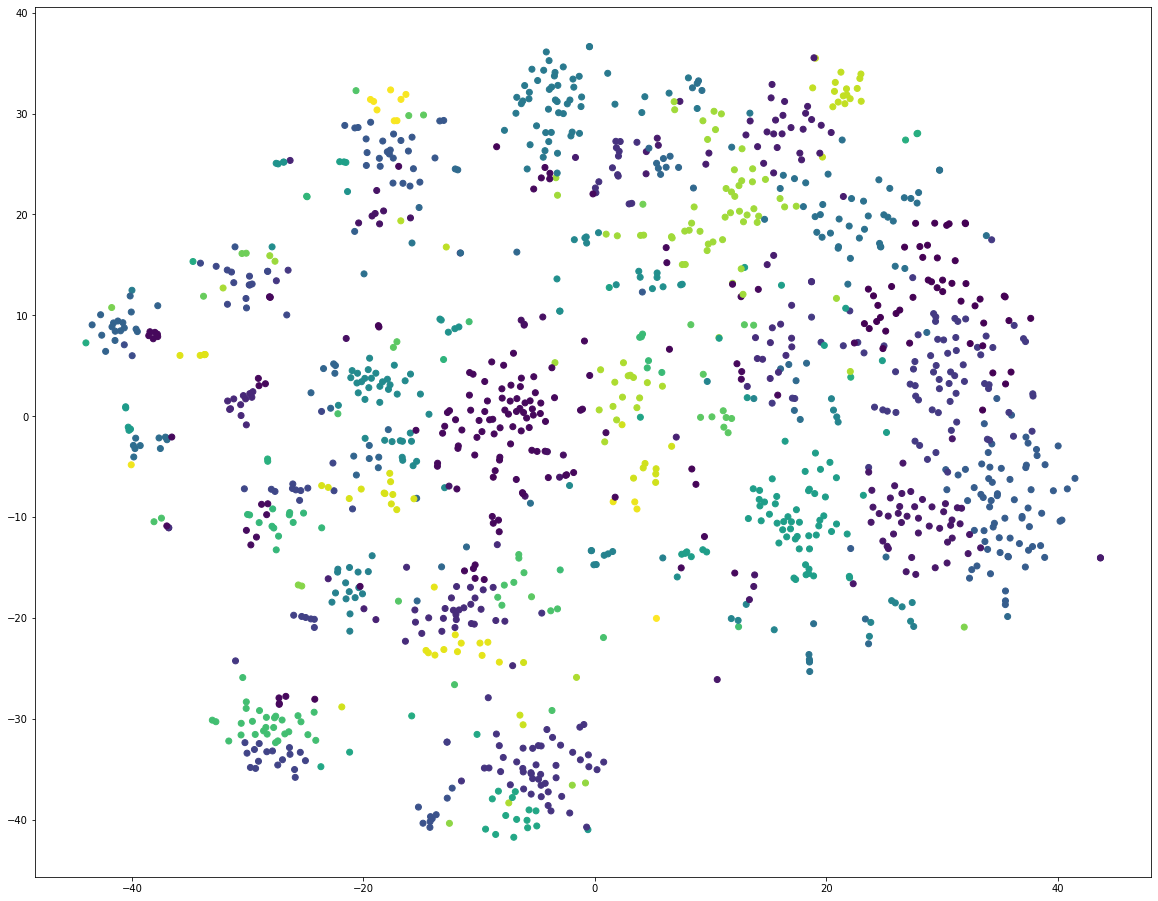

In [187]:
#https://stackoverflow.com/questions/28227340/kmeans-scatter-plot-plot-different-colors-per-cluster
plt.figure(figsize=(20,16))
plt.scatter(movie_embeddings_2d[:,0],movie_embeddings_2d[:,1],c=best_cluster.labels_.astype(float))
plt.show()